# Generacion de muestras

In [1]:
import numpy as np

def generar_muestra_coseno(N, num_cosenos, varianza_ruido):
    """
    Genera un vector de muestras como suma de cosenos con parámetros aleatorios y ruido gaussiano.
    
    Parámetros:
    -----------
    N : int
        Cantidad de muestras a generar.
    num_cosenos : int
        Número de cosenos a sumar.
    varianza_ruido : float
        Varianza del ruido gaussiano agregado.
    
    Retorna:
    --------
    x : ndarray de shape (N,)
        Vector de muestras resultante.
    parametros : list of dict
        Lista con las constantes de cada coseno (amplitud, frecuencia y fase).
    varianza_ruido : float
        Varianza del ruido utilizado.
    """
    t = np.arange(N) / N   # tiempo normalizado entre 0 y 1
    
    # Parámetros aleatorios de los cosenos
    amplitudes = np.random.uniform(0.5, 2.0, num_cosenos)      # amplitudes aleatorias
    frecuencias = np.random.uniform(1, 20, num_cosenos)        # frecuencias aleatorias (en Hz normalizado)
    fases = np.random.uniform(0, 2*np.pi, num_cosenos)         # fases aleatorias
    
    # Generar señal base como suma de cosenos
    x_clean = np.zeros(N)
    for A, f, phi in zip(amplitudes, frecuencias, fases):
        x_clean += A * np.cos(2 * np.pi * f * t + phi)
    
    # Agregar ruido gaussiano
    ruido = np.random.normal(0, np.sqrt(varianza_ruido), N)
    x = x_clean + ruido
    
    # Empaquetar parámetros
    parametros = []
    for A, f, phi in zip(amplitudes, frecuencias, fases):
        parametros.append({
            "amplitud": A,
            "frecuencia": f,
            "fase": phi
        })
    
    return x, parametros, varianza_ruido


# Estimador de 

In [2]:
import numpy as np
from scipy.optimize import curve_fit

def modelo_cosenos(t, *params):
    """
    Modelo de suma de cosenos.
    
    params = [A1, f1, phi1, A2, f2, phi2, ..., An, fn, phin]
    """
    num_cosenos = len(params) // 3
    y = np.zeros_like(t)
    for i in range(num_cosenos):
        A = params[3*i]
        f = params[3*i + 1]
        phi = params[3*i + 2]
        y += A * np.cos(2 * np.pi * f * t + phi)
    return y

def estimar_parametros(y, num_cosenos, max_iter=10000):
    """
    Estima los parámetros de una señal que es suma de cosenos mediante mínimos cuadrados no lineales.
    
    Parámetros:
    -----------
    y : ndarray
        Vector de muestras observadas.
    num_cosenos : int
        Número de cosenos que componen la señal.
    max_iter : int
        Número máximo de iteraciones del optimizador.
    
    Retorna:
    --------
    parametros : list of dict
        Estimación de los parámetros (amplitud, frecuencia, fase).
    """
    N = len(y)
    t = np.arange(N) / N
    
    # Valores iniciales aproximados (necesarios para que converja)
    A0 = np.ones(num_cosenos) * (np.std(y) / num_cosenos)
    f0 = np.linspace(1, 10, num_cosenos)   # inicializar frecuencias en un rango
    phi0 = np.zeros(num_cosenos)
    
    p0 = []
    for A, f, phi in zip(A0, f0, phi0):
        p0 += [A, f, phi]
    p0 = np.array(p0)
    
    # Ajuste no lineal
    popt, _ = curve_fit(modelo_cosenos, t, y, p0=p0, maxfev=max_iter)
    
    # Empaquetar parámetros
    parametros = []
    for i in range(num_cosenos):
        A = popt[3*i]
        f = popt[3*i+1]
        phi = popt[3*i+2]
        parametros.append({
            "amplitud": A,
            "frecuencia": f,
            "fase": phi
        })
    
    return parametros

def reconstruir_senal(N, parametros):
    """
    Reconstruye la señal a partir de parámetros de cosenos.
    
    parametros : list of dict con {"amplitud", "frecuencia", "fase"}
    """
    t = np.arange(N) / N
    y = np.zeros(N)
    for p in parametros:
        y += p["amplitud"] * np.cos(2 * np.pi * p["frecuencia"] * t + p["fase"])
    return t, y



In [3]:
import numpy as np

def estimador_de_orden(y, orden_max, C, max_iter=10000, epsilon=1e-12, devolver_parametros=False):
    """
    Estima el orden óptimo (número de cosenos) usando un criterio:
        Criterio(k) = N * log(var_residuo_k + epsilon) + C * k

    Parámetros
    ----------
    y : ndarray (N,)
        Señal observada.
    orden_max : int
        Orden máximo a evaluar (número máximo de cosenos).
    C : float
        Constante que multiplica al término de penalización por el orden k.
    max_iter : int
        Máx. iteraciones para el optimizador en estimar_parametros.
    epsilon : float
        Pequeño valor para estabilizar el logaritmo.
    devolver_parametros : bool
        Si True, devuelve también los parámetros del orden óptimo.

    Retorna
    -------
    orden_optimo : int
        Orden estimado.
    varianzas : list[float]
        Varianzas del residuo para k = 1..orden_max.
    criterios : list[float]
        Valores del criterio para k = 1..orden_max.
    (opcional) parametros_optimos : list[dict]
        Parámetros {amplitud, frecuencia, fase} del orden óptimo (si devolver_parametros=True).
    """
    N = len(y)
    varianzas = []
    criterios = []
    mejores_parametros = None
    parametros_k_opt = None

    for k in range(1, orden_max + 1):
        try:
            # Estimar parámetros para orden k
            params_k = estimar_parametros(y, num_cosenos=k, max_iter=max_iter)

            # Reconstruir y calcular residuo
            _, y_hat = reconstruir_senal(N, params_k)
            residuo = y - y_hat
            var_est = float(np.mean(residuo**2))

            # Guardar métricas
            varianzas.append(var_est)
            criterio_k = N * np.log(var_est + epsilon) + C * k
            criterios.append(criterio_k)

            # Guardar los parámetros si van siendo los mejores
            if devolver_parametros:
                if (parametros_k_opt is None) or (criterio_k < criterios[parametros_k_opt - 1]):
                    parametros_k_opt = k
                    mejores_parametros = params_k

        except Exception:
            # Si falla el ajuste para este orden, lo penalizamos fuertemente
            varianzas.append(np.inf)
            criterios.append(np.inf)

    # Selección del orden óptimo
    orden_optimo = int(np.argmin(criterios) + 1)

    if devolver_parametros:
        # Si no se setearon (por fallos), intentar reevaluar los del orden óptimo
        if mejores_parametros is None or parametros_k_opt != orden_optimo:
            try:
                mejores_parametros = estimar_parametros(y, num_cosenos=orden_optimo, max_iter=max_iter)
            except Exception:
                mejores_parametros = None
        return orden_optimo, varianzas, criterios, mejores_parametros

    return orden_optimo, varianzas, criterios



In [10]:
# Señal sintética
x, params_true, _ = generar_muestra_coseno(N=500, num_cosenos=3, varianza_ruido=0.05)

# Estimo orden con constante C=5.0 (ajustá C a tu gusto)
orden_opt, vars_k, crits_k, params_opt = estimador_de_orden(
    x, orden_max=8, C=5.50, devolver_parametros=True
)

print("Orden real:", len(params_true))
print("Orden estimado:", orden_opt)
print("Varianzas:", vars_k)
print("Criterios:", crits_k)
print("Parámetros óptimos:", params_opt)


Orden real: 3
Orden estimado: 4
Varianzas: [3.7188377032816926, 3.7099064438728937, 3.6910485044075623, 2.4082977259715626, 2.4043273936036753, inf, 2.389950171990722, inf]
Criterios: [np.float64(662.2055870548606), np.float64(666.503329508359), np.float64(669.455282613183), np.float64(461.46008007889515), np.float64(466.1350972119629), inf, np.float64(474.1362585935285), inf]
Parámetros óptimos: [{'amplitud': np.float64(-0.0480616545387829), 'frecuencia': np.float64(-0.01254727613082784), 'fase': np.float64(5.6630225145901925)}, {'amplitud': np.float64(1.6294124254561178), 'frecuencia': np.float64(3.242768470130581), 'fase': np.float64(1.6525282377898725)}, {'amplitud': np.float64(-0.08429321831662702), 'frecuencia': np.float64(6.9129993235227385), 'fase': np.float64(0.5002733545284419)}, {'amplitud': np.float64(-0.11051057544789585), 'frecuencia': np.float64(9.999389491130865), 'fase': np.float64(0.3362456153446631)}]


Orden real: 3
Tasa de acierto: 0.13333333333333333
Órdenes estimados: [5, 4, 1, 6, 5, 4, 4, 4, 7, 2, 1, 1, 3, 4, 5, 3, 1, 5, 3, 5, 5, 4, 6, 2, 4, 6, 4, 4, 4, 3]


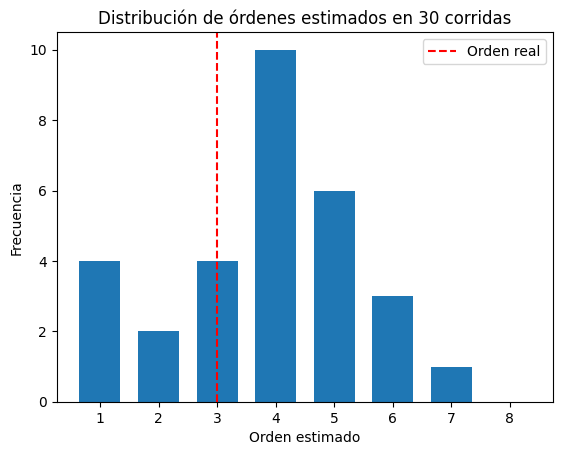

In [20]:
import matplotlib.pyplot as plt

# Parámetros de la simulación
iteraciones = 30
N = 500
orden_real = 3
varianza_ruido = 0.001
orden_max = 8
C = 5.0

ordenes_estimados = []
aciertos = 0

for _ in range(iteraciones):
    # Generar señal sintética con 'orden_real' cosenos
    x, _, _ = generar_muestra_coseno(N=N, num_cosenos=orden_real, varianza_ruido=varianza_ruido)
    
    # Estimar el orden
    orden_est, _, _ = estimador_de_orden(x, orden_max=orden_max, C=C)
    ordenes_estimados.append(orden_est)
    
    if orden_est == orden_real:
        aciertos += 1

# Resultados
print("Orden real:", orden_real)
print("Tasa de acierto:", aciertos / iteraciones)
print("Órdenes estimados:", ordenes_estimados)

# Histograma de órdenes estimados
plt.hist(ordenes_estimados, bins=range(1, orden_max+2), align="left", rwidth=0.7)
plt.axvline(orden_real, color="red", linestyle="--", label="Orden real")
plt.xlabel("Orden estimado")
plt.ylabel("Frecuencia")
plt.title(f"Distribución de órdenes estimados en {iteraciones} corridas")
plt.legend()
plt.show()
